In [5]:
import torch
import torch
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, Sequential, Module
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [6]:
import cv2

In [3]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch

class RAFDBDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
from get_dataset import GiMeFiveDataset

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    # transforms.RandomHorizontalFlip(), 
    # transforms.RandomApply([
    #     transforms.RandomRotation(5),
    #     transforms.RandomCrop(64, padding=8)
    # ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomErasing(scale=(0.02,0.25)),
])
    
# rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/RAF-DB/train_RAF_labels.csv',
#                             img_dir='archive/RAF-DB/train/',
#                             transform=transform)
rafdb_dataset_train = GiMeFiveDataset(csv_file='archive/FER+/train_FER_labels.csv',
                            img_dir='archive/FER+/train/',
                            transform=transform)
data_train_loader = DataLoader(rafdb_dataset_train, batch_size=16, shuffle=True, num_workers=4)
train_image, train_label = next(iter(data_train_loader))
print(f"Train batch: image shape {train_image.shape}, labels shape {train_label.shape}")

rafdb_dataset_vali = GiMeFiveDataset(csv_file='dataset/vali_labels.csv',
                            img_dir='dataset/vali',
                            transform=transform)
data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=16, shuffle=False, num_workers=0)
vali_image, vali_label = next(iter(data_vali_loader))
print(f"Vali batch: image shape {vali_image.shape}, labels shape {vali_label.shape}")

# rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/RAF-DB/test_RAF_labels.csv',
#                             img_dir='archive/RAF-DB/test/',
#                             transform=transform)
rafdb_dataset_test = GiMeFiveDataset(csv_file='archive/FER+/test_FER_labels.csv',
                            img_dir='archive/FER+/test/',
                            transform=transform)
data_test_loader = DataLoader(rafdb_dataset_test, batch_size=16, shuffle=False, num_workers=0)
test_image, test_label = next(iter(data_test_loader))
print(f"Test batch: image shape {test_image.shape}, labels shape {test_label.shape}")

Train batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Vali batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])
Test batch: image shape torch.Size([16, 3, 64, 64]), labels shape torch.Size([16])


In [9]:
# for images, labels in data_train_loader:
#     labels = labels - 1
#     if labels.min() < 0 or labels.max() > 5:
#         print("Found label outside the expected range [0, 5]")
#         break

# for images, labels in data_vali_loader:
#     labels = labels - 1
#     if labels.min() < 0 or labels.max() > 5:
#         print("Found label outside the expected range [0, 5]")
#         break

# for images, labels in data_test_loader:
#     labels = labels - 1
#     if labels.min() < 0 or labels.max() > 5:
#         print("Found label outside the expected range [0, 5]")
#         break


In [10]:
class SEBlock(nn.Module): # Squeeze-and-Excitation (SE) blocks apply channel-wise attention.
    def __init__(self, input_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_channels, input_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_channels // reduction, input_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        out = F.relu(out)
        return out

In [12]:
# Residual 
# class EmotionClassifier(nn.Module):
#     def __init__(self):
#         super(EmotionClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.se1 = SEBlock(64)

#         # Using Residual Blocks
#         self.res_block1 = ResidualBlock(64, 128, stride=2)
#         self.res_block2 = ResidualBlock(128, 256, stride=2)
#         self.res_block3 = ResidualBlock(256, 512, stride=2)
#         self.res_block4 = ResidualBlock(512, 1024, stride=2)

#         self.pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc1 = nn.Linear(1024, 2048)
#         self.fc2 = nn.Linear(2048, 1024) 
#         self.dropout1 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(1024, 6)

#     def forward(self, x):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.se1(x)
        
#         x = self.res_block1(x)
#         x = self.res_block2(x)
#         x = self.res_block3(x)
#         x = self.res_block4(x)
        
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
# model = EmotionClassifier().to(device)

In [17]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        # self.se1 = SEBlock(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 1024) 
        self.dropout1 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 6)
        self.gradients = None ### GradCAM
        self.activations = None ### GradCAM

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        # x = self.se1(x)
        # x = F.relu(self.se1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        self.activations = x ### GradCAM
        x.register_hook(self.activations_hook) ### GradCAM
        x = F.max_pool2d(x, 2)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # def get_activations_gradients(self, x):
    #     self.gradients = None
    #     def hook_function(module, grad_in, grad_out):
    #         self.gradients = grad_out[0]
    #     h = self.conv5.register_backward_hook(hook_function)
    #     activations = self.conv5(x)
    #     h.remove()  
    #     return activations

    # def get_gradients(self):
    #     return self.gradients
    
    def get_activations_gradients(self):
        return self.gradients

model = EmotionClassifier()# .to(device)

In [28]:
def grad_cam(model, x, class_idx):
    model.load_state_dict(torch.load('best_RAF.pth', map_location=torch.device('cpu')))
    model.eval()
    outputs = model(x)
    one_hot_output = torch.zeros_like(outputs)
    one_hot_output[0, class_idx] = 1
    outputs.backward(gradient=one_hot_output)
    gradients = model.get_activations_gradients()
    activations = model.activations 
    # model.zero_grad()
    # one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
    # one_hot_output[0][class_idx] = 1
    # output.backward(gradient=one_hot_output, retain_graph=True)
    # gradients = model.get_gradients()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    # activations = model.get_activations_gradients(x)
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    return heatmap.data

In [39]:
from torchvision import transforms
from PIL import Image
import torch

# image_path = 'dataset/vali/img000_surprise.jpg'
# image_path = 'dataset/vali/img387_happiness.jpg'
image_path = 'archive/RAF-DB/train/train_00004_aligned_happiness.jpg'
# image_path = 'archive/RAF-DB/test/test_0001_aligned_sadness.jpg'
image = Image.open(image_path)

preprocess = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocessed_image = preprocess(image)
preprocessed_image = preprocessed_image.unsqueeze(0)
outputs = model(preprocessed_image)

_, predicted_class = torch.max(outputs.data, 1)
class_idx = predicted_class.item()

In [40]:
gcam = grad_cam(model, preprocessed_image, class_idx)

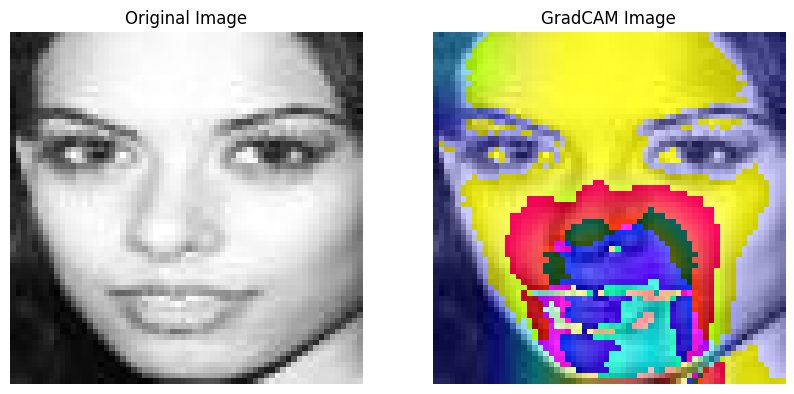

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

gcam_np = gcam.cpu().numpy()
gcam_np = (gcam_np - np.min(gcam_np)) / (np.max(gcam_np) - np.min(gcam_np))

gcam_resized = cv2.resize(gcam_np, (64, 64))

gcam_rgb = np.uint8(255 * gcam_resized)

gcam_colored = cv2.applyColorMap(gcam_rgb, cv2.COLORMAP_JET)

original_image = cv2.imread(image_path)
original_image = cv2.resize(original_image, (64, 64))

original_image_float = original_image.astype(np.float32) / 255.0
gcam_colored_float = gcam_colored.astype(np.float32) / 255.0

superimposed_img = gcam_colored_float * 0.4 + original_image_float
superimposed_img = np.uint8(255 * superimposed_img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('GradCAM Image')
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

In [5]:
# model.load_state_dict(torch.load('best_baseline.pth', map_location=device))
# model.eval()

EmotionClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc2): Linear(in_features

In [6]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 10478086


In [15]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class BasicBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_planes, planes, stride=1):
#         super(BasicBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(planes)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_planes != self.expansion * planes:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * planes)
#             )

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = F.relu(out)
#         return out

# class ResNet(nn.Module):
#     def __init__(self, block, num_blocks, num_classes=6):
#         super(ResNet, self).__init__()
#         self.in_planes = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
#         self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
#         self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)

#     def _make_layer(self, block, planes, num_blocks, stride):
#         strides = [stride] + [1]*(num_blocks-1)
#         layers = []
#         for stride in strides:
#             layers.append(block(self.in_planes, planes, stride))
#             self.in_planes = planes * block.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out

# def EmotionClassifierResNet18():
#     return ResNet(BasicBlock, [2, 2, 2, 2])

# model = EmotionClassifierResNet18().to(device)


In [16]:
# import torch.nn as nn
# import torch.nn.functional as F

# class VGGEmotionClassifier(nn.Module):
#     def __init__(self):
#         super(VGGEmotionClassifier, self).__init__()
        
#         self.features = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(16384, 4096), 
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(4096, 1024),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(1024, 6)  
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x

# model = VGGEmotionClassifier().to(device)

In [17]:
# param_grid = {
#     'lr': [0.1, 0.01, 0.001, 0.0001], 
#     'batch_size': [8, 16, 32, 64],  
# }
# grid = ParameterGrid(param_grid)
# results = []

In [18]:
# for params in grid: # Hyperparameter tuning 
#     data_train_loader = DataLoader(rafdb_dataset_train, batch_size=params['batch_size'], shuffle=True, num_workers=4)
#     data_vali_loader = DataLoader(rafdb_dataset_vali, batch_size=params['batch_size'], shuffle=False, num_workers=0)
    
#     model = EmotionClassifier().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=params['lr'])
#     criterion = nn.CrossEntropyLoss()
    
#     best_val_acc = 0
#     num_epochs = 15
    
#     for epoch in range(num_epochs):
#         model.train()
#         for i, data in enumerate(tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"), 0):
#             inputs, labels = data[0].to(device), data[1].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     model.eval()
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for data in data_vali_loader:
#             inputs, labels = data[0].to(device), data[1].to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()
    
#     val_acc = val_correct / val_total
#     best_val_acc = max(best_val_acc, val_acc)
    
#     results.append({
#         'lr': params['lr'],
#         'batch_size': params['batch_size'],
#         'best_val_acc': best_val_acc,
#     })

# for result in results:
#     print(f"LR: {result['lr']}, Batch Size: {result['batch_size']}, Best Val Acc: {result['best_val_acc']}")

# best_params = max(results, key=lambda x: x['best_val_acc'])
# print(f"Best params: {best_params}")

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # test 5/0.5 later

patience = 5
best_val_acc = 0  
patience_counter = 0

num_epochs = 40

In [8]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(data_train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(data_train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for data in data_test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(data_test_loader)
    test_acc = test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in data_vali_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(data_vali_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement in validation accuracy for {patience_counter} epochs.")
    
    if patience_counter > patience:
        print("Stopping early due to lack of improvement in validation accuracy.")
        break

Epoch 1/40: 100%|██████████| 1484/1484 [01:26<00:00, 17.16it/s]


Epoch 1, Train Loss: 1.5576017519052459, Train Accuracy: 0.34310504591020136, Test Loss: 1.3771462398831562, Test Accuracy: 0.45046257359125313, Validation Loss: 2.066038291705282, Validation Accuracy: 0.18363939899833054


Epoch 2/40: 100%|██████████| 1484/1484 [01:22<00:00, 18.02it/s]


Epoch 2, Train Loss: 1.3187541392132278, Train Accuracy: 0.46234521101844833, Test Loss: 1.2754762895325178, Test Accuracy: 0.5162321278385198, Validation Loss: 2.0059990224085356, Validation Accuracy: 0.2654424040066778


Epoch 3/40: 100%|██████████| 1484/1484 [01:22<00:00, 18.02it/s]


Epoch 3, Train Loss: 1.1864605457634938, Train Accuracy: 0.5138994187515795, Test Loss: 1.1787602646696953, Test Accuracy: 0.5093355761143818, Validation Loss: 2.0220167072195756, Validation Accuracy: 0.2671118530884808


Epoch 4/40: 100%|██████████| 1484/1484 [01:22<00:00, 18.05it/s]


Epoch 4, Train Loss: 1.111187338045826, Train Accuracy: 0.5410243450425406, Test Loss: 1.1243034756632262, Test Accuracy: 0.5633305298570227, Validation Loss: 1.945123459163465, Validation Accuracy: 0.3055091819699499


Epoch 5/40: 100%|██████████| 1484/1484 [01:22<00:00, 18.03it/s]


Epoch 5, Train Loss: 1.0537540805990484, Train Accuracy: 0.5667172100075815, Test Loss: 1.190162277189634, Test Accuracy: 0.5352396972245584, Validation Loss: 2.0147376844757483, Validation Accuracy: 0.28046744574290483
No improvement in validation accuracy for 1 epochs.


Epoch 6/40: 100%|██████████| 1484/1484 [01:23<00:00, 17.81it/s]


Epoch 6, Train Loss: 0.9905221520087147, Train Accuracy: 0.5976750063179176, Test Loss: 1.0702375024957682, Test Accuracy: 0.576619007569386, Validation Loss: 2.0852025496332267, Validation Accuracy: 0.3088480801335559


Epoch 7/40: 100%|██████████| 1484/1484 [01:22<00:00, 17.94it/s]


Epoch 7, Train Loss: 0.9225103748897016, Train Accuracy: 0.624715693707354, Test Loss: 1.0432694168981684, Test Accuracy: 0.5983179142136249, Validation Loss: 2.0846010007356344, Validation Accuracy: 0.33889816360601


Epoch 8/40: 100%|██████████| 1484/1484 [01:22<00:00, 17.92it/s]


Epoch 8, Train Loss: 0.8623080880373636, Train Accuracy: 0.65192485889984, Test Loss: 1.005008448836624, Test Accuracy: 0.6146341463414634, Validation Loss: 2.024063147996601, Validation Accuracy: 0.3622704507512521


Epoch 9/40: 100%|██████████| 1484/1484 [01:23<00:00, 17.75it/s]


Epoch 9, Train Loss: 0.8017068868176636, Train Accuracy: 0.6825035801533148, Test Loss: 1.0137762231652134, Test Accuracy: 0.6105971404541631, Validation Loss: 2.109089399638929, Validation Accuracy: 0.35392320534223703
No improvement in validation accuracy for 1 epochs.


Epoch 10/40: 100%|██████████| 1484/1484 [01:22<00:00, 17.94it/s]


Epoch 10, Train Loss: 0.7337462034206989, Train Accuracy: 0.7124926290961165, Test Loss: 1.0060431547062372, Test Accuracy: 0.631623212783852, Validation Loss: 1.9880490208926953, Validation Accuracy: 0.38564273789649417


Epoch 11/40: 100%|██████████| 1484/1484 [01:23<00:00, 17.85it/s]


Epoch 11, Train Loss: 0.6709742177769823, Train Accuracy: 0.7463145480582933, Test Loss: 1.1078103040094658, Test Accuracy: 0.591757779646762, Validation Loss: 2.062623729831294, Validation Accuracy: 0.36894824707846413
No improvement in validation accuracy for 1 epochs.


Epoch 12/40: 100%|██████████| 1484/1484 [01:23<00:00, 17.79it/s]


Epoch 12, Train Loss: 0.6177482380860578, Train Accuracy: 0.7696066043298795, Test Loss: 1.002693445081272, Test Accuracy: 0.6420521446593777, Validation Loss: 2.0412449115201046, Validation Accuracy: 0.4073455759599332


Epoch 13/40: 100%|██████████| 1484/1484 [01:22<00:00, 17.92it/s]


Epoch 13, Train Loss: 0.558356662830614, Train Accuracy: 0.7979108752421868, Test Loss: 1.1122630392752026, Test Accuracy: 0.6132884777123633, Validation Loss: 2.5865045095744885, Validation Accuracy: 0.33889816360601
No improvement in validation accuracy for 1 epochs.


Epoch 14/40: 100%|██████████| 1484/1484 [01:22<00:00, 17.90it/s]


Epoch 14, Train Loss: 0.5007325501364437, Train Accuracy: 0.8222137983320698, Test Loss: 1.0826042021314304, Test Accuracy: 0.632968881412952, Validation Loss: 2.323637378843207, Validation Accuracy: 0.38898163606010017
No improvement in validation accuracy for 2 epochs.


Epoch 15/40: 100%|██████████| 1484/1484 [01:23<00:00, 17.81it/s]


Epoch 15, Train Loss: 0.44340625145495177, Train Accuracy: 0.8495914413276051, Test Loss: 1.0260294358476356, Test Accuracy: 0.6524810765349033, Validation Loss: 2.376062430833515, Validation Accuracy: 0.39065108514190316
No improvement in validation accuracy for 3 epochs.


Epoch 16/40: 100%|██████████| 1484/1484 [01:23<00:00, 17.69it/s]


Epoch 16, Train Loss: 0.3994336383959474, Train Accuracy: 0.8686294330721928, Test Loss: 1.0313689398068575, Test Accuracy: 0.6548359966358285, Validation Loss: 2.410498001073536, Validation Accuracy: 0.39232053422370616
No improvement in validation accuracy for 4 epochs.


Epoch 17/40: 100%|██████████| 1484/1484 [01:24<00:00, 17.61it/s]


Epoch 17, Train Loss: 0.3630865738724642, Train Accuracy: 0.8824867323730099, Test Loss: 1.0876647817591827, Test Accuracy: 0.656013456686291, Validation Loss: 2.5617290797986483, Validation Accuracy: 0.3989983305509182
No improvement in validation accuracy for 5 epochs.


Epoch 18/40: 100%|██████████| 1484/1484 [01:22<00:00, 17.89it/s]


Epoch 18, Train Loss: 0.3281485672256937, Train Accuracy: 0.895754359363154, Test Loss: 1.1449538686523033, Test Accuracy: 0.6361648444070648, Validation Loss: 2.7509905758656954, Validation Accuracy: 0.3789649415692821
No improvement in validation accuracy for 6 epochs.
Stopping early due to lack of improvement in validation accuracy.


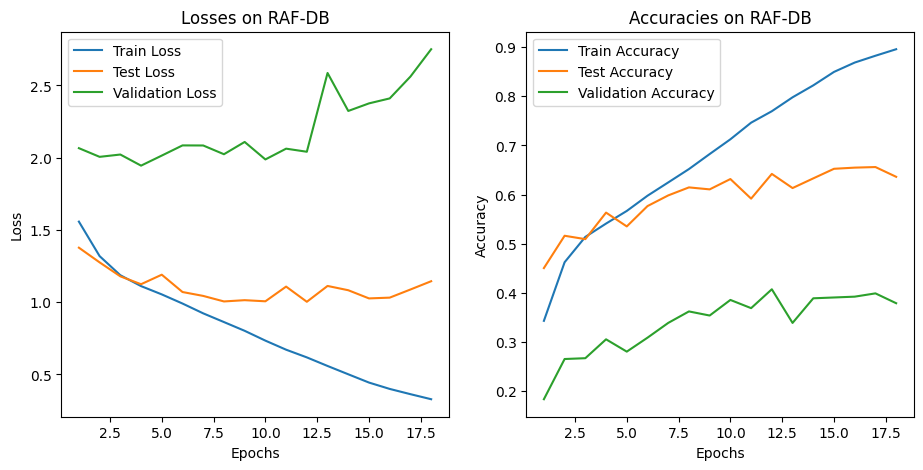

In [9]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, 19), train_losses, label='Train Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 19), test_losses, label='Test Loss') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 19), val_losses, label='Validation Loss') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses on FER+')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, 19), train_accuracies, label='Train Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 19), test_accuracies, label='Test Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.plot(range(1, 19), val_accuracies, label='Validation Accuracy') # change this number after '(1, _)' to num_epochs+1
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracies on FER+')
plt.legend()

plt.show()

In [10]:
df = pd.DataFrame({
    'Epoch': range(1, 19), # change this number after '(1, _)' to num_epochs+1
    'Train Loss': train_losses,
    'Test Loss': test_losses,
    'Validation Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Validation Accuracy': val_accuracies
})
df.to_csv('result_FER.csv', index=False) # change this CSV

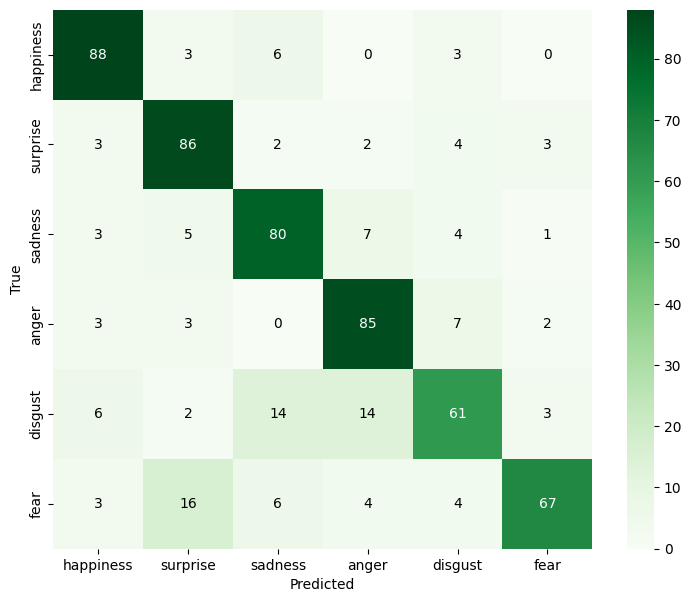

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('classification_scores_valid.csv')
class_names = ['happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']
df['true'] = df['filepath'].apply(lambda x: x.split('_')[1].split('.')[0])
df['predicted'] = df[class_names].idxmax(axis=1)

confusion_matrix = pd.crosstab(df['true'], df['predicted'], rownames=['True'], colnames=['Predicted'])
confusion_matrix = confusion_matrix.reindex(index=class_names, columns=class_names, fill_value=0)

plt.figure(figsize=(9, 7))
ax = sns.heatmap(confusion_matrix, fmt="d", cmap='Greens', square=True, cbar=True, annot_kws=None) # cmap= PiYG, Blues, BuPu
for i, row in enumerate(confusion_matrix.values):
    for j, val in enumerate(row):
        text_color = 'white' if i == j else 'black'
        ax.text(j+0.5, i+0.5, val, color=text_color, ha='center', va='center')
plt.show()
